<a href="https://colab.research.google.com/github/PawanSths/AI-agents/blob/main/Goal_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

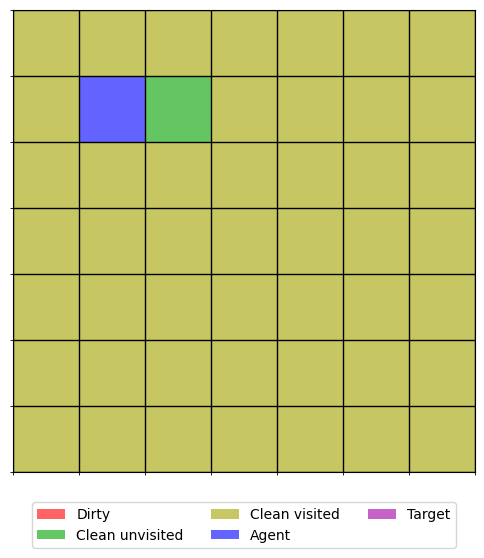

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import heapq
from IPython.display import HTML

# Simulation parameters
GRID_SIZE = 7
INTERVAL_MS = 200   # milliseconds per frame
NUM_EPISODES = 3    # how many times to respawn & run

# Colors for visualization (RGB)
COLORS = {
    'dirty':   (1.00, 0.39, 0.39),  # Red
    'clean':   (0.39, 0.78, 0.39),  # Green
    'agent':   (0.39, 0.39, 1.00),  # Blue
    'visited': (0.78, 0.78, 0.39),  # Yellow
    'target':  (0.78, 0.39, 0.78)   # Purple (target tile)
}

class UtilityBasedVacuumAgent:
    def __init__(self, size):
        self.size = size

    def reset(self):
        # New random dirt layout + random spawn
        self.grid = np.random.randint(0, 2, (self.size, self.size))
        self.pos = (random.randrange(self.size), random.randrange(self.size))
        self.visited = {self.pos}
        self.cleaned = 0
        self.steps = 0
        self.target = None
        self.path = []

    def neighbors(self, x, y):
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
                yield (nx, ny)

    def find_closest_dirty(self):
        """Find the closest dirty tile using BFS"""
        if np.all(self.grid == 1):
            return None
        from collections import deque
        queue = deque([(self.pos, [])])
        seen = {self.pos}
        while queue:
            (x, y), path = queue.popleft()
            if self.grid[x, y] == 0:
                return path
            for nb in self.neighbors(x, y):
                if nb not in seen:
                    seen.add(nb)
                    queue.append((nb, path + [nb]))
        return None

    def step(self):
        self.steps += 1
        x, y = self.pos

        # 1) Clean if dirty
        if self.grid[x, y] == 0:
            self.grid[x, y] = 1
            self.cleaned += 1
            self.target = None
            self.path = []
            self.visited.add((x, y))
            return True

        # 2) Follow existing path
        if self.path:
            self.pos = self.path.pop(0)
            self.visited.add(self.pos)
            if not self.path and self.grid[self.pos] == 0:
                self.target = self.pos
            return True

        # 3) Compute new path to closest dirty
        new_path = self.find_closest_dirty()
        if new_path:
            self.path = new_path
            self.target = self.path[-1]
            return self.step()

        # 4) Explore unvisited
        unvisited = [(i, j) for i in range(self.size) for j in range(self.size) if (i, j) not in self.visited]
        if unvisited:
            # pick nearest
            unvisited.sort(key=lambda p: abs(p[0]-x) + abs(p[1]-y))
            tx, ty = unvisited[0]
            dx = tx - x
            dy = ty - y
            if abs(dx) > abs(dy):
                nx, ny = x + np.sign(dx), y
            else:
                nx, ny = x, y + np.sign(dy)
            self.pos = (int(nx), int(ny))
            self.visited.add(self.pos)
            return True

        # 5) Random move fallback
        nbrs = list(self.neighbors(x, y))
        if nbrs:
            self.pos = random.choice(nbrs)
            self.visited.add(self.pos)
            return True

        return False

    def run_episode(self):
        frames = []
        total_cells = self.size * self.size
        # corrected while condition
        while not (np.all(self.grid == 1) and len(self.visited) == total_cells):
            # record frame
            frame = np.zeros((self.size, self.size, 3))
            for i in range(self.size):
                for j in range(self.size):
                    if (i, j) == self.pos:
                        frame[i, j] = COLORS['agent']
                    elif self.grid[i, j] == 0:
                        frame[i, j] = COLORS['dirty']
                    elif (i, j) in self.visited:
                        frame[i, j] = COLORS['visited']
                    else:
                        frame[i, j] = COLORS['clean']
                    if self.target == (i, j):
                        frame[i, j] = COLORS['target']
            frames.append(frame)
            self.step()
        return frames

# Run multiple episodes and gather frames
agent = UtilityBasedVacuumAgent(GRID_SIZE)
all_frames = []
for _ in range(NUM_EPISODES):
    agent.reset()
    all_frames.extend(agent.run_episode())

# Create animation
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(all_frames[0], interpolation='nearest')

# Add grid lines
ax.set_xticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-.5, GRID_SIZE, 1), minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim(-0.5, GRID_SIZE - 0.5)
ax.set_ylim(GRID_SIZE - 0.5, -0.5)

# Legend
from matplotlib.patches import Patch
legend_elems = [
    Patch(facecolor=COLORS['dirty'], label='Dirty'),
    Patch(facecolor=COLORS['clean'], label='Clean unvisited'),
    Patch(facecolor=COLORS['visited'], label='Clean visited'),
    Patch(facecolor=COLORS['agent'], label='Agent'),
    Patch(facecolor=COLORS['target'], label='Target'),
]
ax.legend(handles=legend_elems, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=all_frames, interval=INTERVAL_MS, blit=True)
HTML(ani.to_jshtml())
